# BD04 Data Science - Casus Anomaly Detection

#### Projectleden:
Chantal Favié, Kane Doornbos, Max Smeets, Sabrine Bouchmal

### Opdrachtgevers/begeleiders
Jan Baljan, Maarten Vaessen, Roel Bindels 


## Aanleiding

TODO: Omschrijven

Kinderen met de zeldzame spierziekte JDM (Juveniele Dermatomyositis) worden met behulp van de
Childhood Myositis Assessment Scale (CMAS) gemonitoord. Met de CMAS is het mogelijk om
spierzwakte te kunnen meten. De CMAS-meting is kort gezegd de maatstaaf die gebruikt wordt om
kinderen te meten met de zeldzame spierzwakte JDM. De kinderen moeten hiervoor frequent naar
het ziekenhuis voor behandelingen en de CMAS-meting. Door gebruik te maken van iDBPS kan de
meting op een laagdrempelige manier thuis worden uitgevoerd. Er wordt voor deze meting door
iDBPS alleen gebruik gemaakt van een camera, zoals deze aanwezig is in de huidige laptops en
mobiele telefoons. Hiervoor wordt gebruik gemaakt van kunstmatige intelligentie die de
lichaamshouding analyseert. De oefeningen kunnen dan door het kind thuis worden uitgevoerd.
De pipeline voor iDBPS bestaat uit 2 delen. In het eerste deel wordt een AI model ingezet om op
basis van een camera beeld de persoon en de postitie van de lichaamsdelen te herkennen. In het 2e
deel worden deze informatie gebruikt om een bepaalde lichaamshouding te herkennen en
automatisch te scoren. Voor dit 2e deel is het belangrijk dat de data uit de lichaamsherkenning
betrouwbaar en van hoge kwaliteit is. Bij de huidige AI modellen is dit niet altijd het geval en hier
zoeken wij een oplossing voor.

## Doelstelling

TODO: Omschrijven

Het doel van de casus is het onderzoeken, ontwerpen en realiseren van een methode die als input
de output van een lichaamsherkenning AI-model neemt en 1) bepaald of deze betrouwbaar en van
hoge kwaliteit is, 2) zo mogelijk, deze "repareert" en alsnog bruikbaar maakt voor de rest van de
pipeline.


## Dataset omschrijving
Voor de rauwe data worden video opnamens gemaakt van bepaalde fysieke bewegingen.
Videodata wordt vervolgens geanalyseerd door een pose detectie model waar diverse herkenningspunten op het lichaam geregistreerd worden. Dit resulteert in een json bestand waar voor elk herkenningspunt op vaste intervals de x en y coordinaat binnen het canvas opgeslagen worden.

Een voorbeeld momentopname van een herkenningspunt ziet er als volgt uit:
```
{
        "_index": "logstash-2021.03.10-000001",
        "_type": "_doc",
        "_id": "Kw1eHHgBhLy4-w68XmUL",
        "_score": 1.0,
        "_source": {
                "frameDate": "2021-03-10T13:40:49.336Z",
                "y": 256.41362694914704,
                "x": 371.01454493600573,
                "keypointName": "leftElbow",
                "keypointScore": 0.8112194538116455,
                "@version": "1",
                "frameScore": 0.644375700284453,
                "testStart": "2021-03-10T13:40:45.594Z",
                "elapsedSeconds": 3875,
                "@timestamp": "2021-03-10T13:40:49.773Z"
        }
}
```

## Data retrieval

Data wordt in de volgende mapstructuur opgeslagen:
- data
  - testpersoon
    - testgegevens

Om al deze gegevens in een enkele dataset te verwerken is een alogritme nodig om deze folders te kunnen parsen.

#### Algoritme requirements
- Kan het pad naar de JSON file vanuit de root folder genereren.
- Kan JSON bestanden inlezen.
- Kan meerdere JSON bestanden combineren naar een enkele dataframe.
- Kan onderscheid maken tussen de verschillende soorten oefeningen.
- Is eenvoudig uitbreidbaar met nieuwe oefeningen en/of testpersonen.
- Heeft een tijdscomplexiteit lager dan O(N²)

Allereerst worden verschillende libraries geïmporteerd die van belang zijn voor de code. De geïmporteerde bibliotheken zijn pandas, numpy, matplotlib.pyplot, seaborn, json en os.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os

Hieronder wordt er een functie gebruikt van de pandas library om het maximum aantal kolommen in het dataframe die weer wordt gegeven naar 100 verhoofd. Dit wordt gedaan om de dataset zo goed mogelijk te kunnen analyseren en alle kolommen met gegevens in één oogopslag te kunnen weergeven. 

In [2]:
# Increase max columns
pd.set_option('display.max_columns',100)

Er wordt een lege dictionary gemaakt die files heet, om bestandspaths in op te slaan op basis van de type oefening. Vervolgens De JSON-bestanden die een specifiek woord bevatten, worden in het bestandspath toegevoegd van de bijbehorende lijst in de files-dictonary. 

In [4]:
# Empty files dictionary
files = {"arm": [],"raap": [],"zit": []}
# Define base path
path = './data/'
dir_list = os.listdir(path)
# Check for person folders in base path
# Index 0 = metingen.csv therefore index starts at 1
for folder in range(1, len(dir_list)):
    # Iterate subfolder for files
    sub_dir_list = os.listdir('./data/' + dir_list[folder])
    # Check for json file and exercise type
    # Add to corresponding dictionary key
    for person in range(len(sub_dir_list)):
        # Define path for each file
        item = path + str(dir_list[folder]) + '/' + str(sub_dir_list[person]) 
        if '.json' in item:
            if 'Zit' in item:
                files['zit'].append(item)
            elif 'Raap' in item:
                files['raap'].append(item)
            elif 'Arm' in item:
                files['arm'].append(item)
            else:
                print('Unknown exercise')

NotADirectoryError: [Errno 20] Not a directory: './data/metingen.csv'

Allereerst wordt er een lege dataframe aangemaakt. Daarna wordt er door de for-loops de gegevens van de JSON-bestanden toegevoegd aan de dataframe. Hierdoor worden de verschillende JSON-bestanden samengevoegd. 

In [5]:
df = pd.DataFrame([])

# Loop through exercise dictionary keys
for i in files:
    # Concatinate json files to dataframe
    for file in range(len(files[i])):
        with open(files[i][file]) as data_file:
            data = json.load(data_file)
            df = pd.concat([df, pd.json_normalize(data['hits']['hits'])])

## Data Cleaning

De Data Cleaning stap is een belangrijke stap om ontbrekende waarden, onnauwkeurige waarden en inconsistenties in de dataset mee aan te pakken, waardoor de analyses betrouwbaarder en nauwkeuriger worden. 

Voor de eerste stap binnen de Data Cleaning stap worden een aantal kolommen verwijderd uit de dataframe, omdat deze niet gebruikt kan worden in verschillende berekeningen. De dataset wordt hieronder weergegeven na het verwijderen van de niet berekenbare kolommen. 

In [6]:
# Drop non computable columns
df = df.drop(axis=1, labels=['_index', '_type', 
                             '_score', '_source.y', 
                             '_source.x', '_source.@version', 
                             '_source.elapsedSeconds', 
                             '_source.testStart', 
                             '_source.@timestamp'])

df

,_id,_source.frameDate,_source.keypointName,_source.keypointScore,_source.frameScore
0,XS7tP3gBhLy4-w68gvWS,2021-03-17T11:23:54.856Z,leftWrist,0.865379,0.896748
1,Xi7tP3gBhLy4-w68gvWS,2021-03-17T11:23:54.856Z,rightElbow,0.970615,0.896748
2,2y7tP3gBhLy4-w68gvWT,2021-03-17T11:23:54.856Z,rightWrist,0.832488,0.896748
3,Fi7tP3gBhLy4-w68gvWN,2021-03-17T11:23:53.607Z,rightEar,0.846377,0.908384
4,Fy7tP3gBhLy4-w68gvWN,2021-03-17T11:23:53.607Z,leftEar,0.340297,0.908384
...,...,...,...,...,...
913,XlloY3gBhLy4-w688SmJ,2021-03-24T08:45:22.018Z,rightShoulder,0.994673,0.927028
914,X1loY3gBhLy4-w688SmJ,2021-03-24T08:45:22.018Z,leftEar,0.506128,0.927028
915,t1loY3gBhLy4-w688SmK,2021-03-24T08:45:21.682Z,leftHip,0.987860,0.922765
916,Y1loY3gBhLy4-w688SmJ,2021-03-24T08:45:21.911Z,rightHip,0.995808,0.933177


In de code hieronder wordt doormiddel van een een functie informatie gegeven over de kolomtypes in de dataframe.Het vat de kolommen, het aantal non-null waardes en de datatypes samen. 

In [7]:
# Dataframe column types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35496 entries, 0 to 917
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   _id                    35496 non-null  object 
 1   _source.frameDate      35496 non-null  object 
 2   _source.keypointName   35496 non-null  object 
 3   _source.keypointScore  35496 non-null  float64
 4   _source.frameScore     35496 non-null  float64
dtypes: float64(2), object(3)
memory usage: 1.6+ MB


Hierna wordt de dataset gecontroleerd op ontbrekende waarden per kolom. 

In [8]:
# Checking for missing values
df.isna().sum()


_id                      0
_source.frameDate        0
_source.keypointName     0
_source.keypointScore    0
_source.frameScore       0
dtype: int64

In de code hieronder worden de gemiddelde, de standdaarddeviatie, de minimale waarde, de maximale waarde van de kolom "keypointScore" uitgerekend. Dit geeft inzicht in de verdelingen van de waarden in de gehele kolom.

In [9]:
# Keypoint score statistics
df['_source.keypointScore'].describe()

count    35496.000000
mean         0.905565
std          0.168370
min          0.003566
25%          0.896568
50%          0.985702
75%          0.995841
max          0.999639
Name: _source.keypointScore, dtype: float64

Hetzelfde wordt berekend voor de kolom "frameScore".

In [10]:
# Frame score statistics
df['_source.frameScore'].describe()

count    35496.000000
mean         0.905565
std          0.099525
min          0.170861
25%          0.913137
50%          0.941008
75%          0.952002
max          0.966128
Name: _source.frameScore, dtype: float64

Hieronder wordt in de code het gemiddelde berekend van de kolommen "keypointScore" en "frameScore" voor elke unieke waarde in de kolom "keypointName". Deze gemiddeldes worden in een nieuwe dataframe geplaatst. 

In [11]:
# Get mean keypoint and frame scores for every keypoint
df_means = df.groupby('_source.keypointName').mean(numeric_only=True)
df_means = df_means.reset_index()

df_means

,_source.keypointName,_source.keypointScore,_source.frameScore
0,leftAnkle,0.878832,0.905565
1,leftEar,0.651321,0.905565
2,leftElbow,0.945802,0.905565
3,leftEye,0.895820,0.905565
4,leftHip,0.983399,0.905565
5,leftKnee,0.978888,0.905565
6,leftShoulder,0.971800,0.905565
7,leftWrist,0.918279,0.905565
8,nose,0.917718,0.905565
9,rightAnkle,0.855357,0.905565


## Data visualisation

Na het schoonmaken van de data wordt de data gevisualiseerd. Het visueel weergeven van gegevens vermakkelijkt het ontdekken van patronen en inzichten die anders moeilijk te herkennen zijn. 

Hieronder wordt eerst een gezamelijke plot gemaakt van de gemiddeldes van elke "keypointName". Hiervoor worden de x en y waardes meegegeven, namelijk de waarde in "keypointScore" kolom en de waardes in de "frameScore" kolom. Er is ook gebruik gemaakt van verschillende kleuren om de verschillende categorieen weer te geven. 

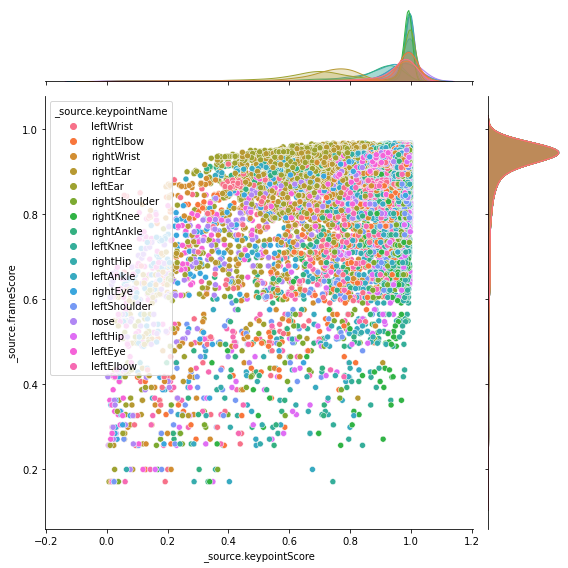

In [33]:
# Categorical jointplot
sns.jointplot(data=df, 
              x="_source.keypointScore", 
              y="_source.frameScore", 
              hue='_source.keypointName',
              height=8,
              ratio=5
            )

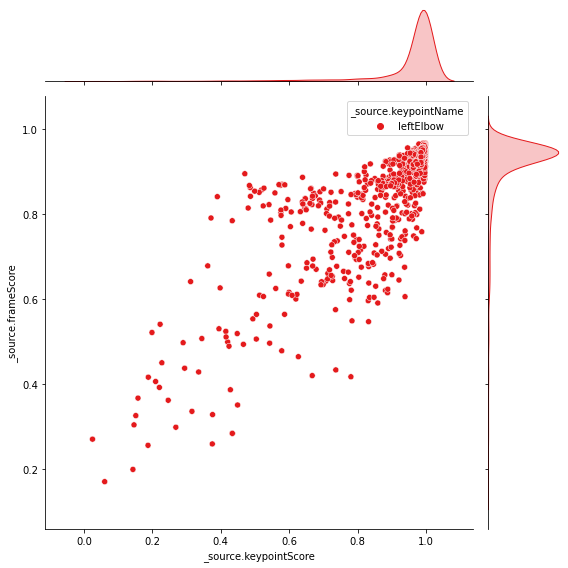

In [40]:
selected_keypoint = 'leftElbow'

sns.jointplot(data=df[df['_source.keypointName'] == selected_keypoint],
              x="_source.keypointScore",
              y="_source.frameScore",
              hue='_source.keypointName',
              palette='Set1',
              height=8,
              ratio=5)

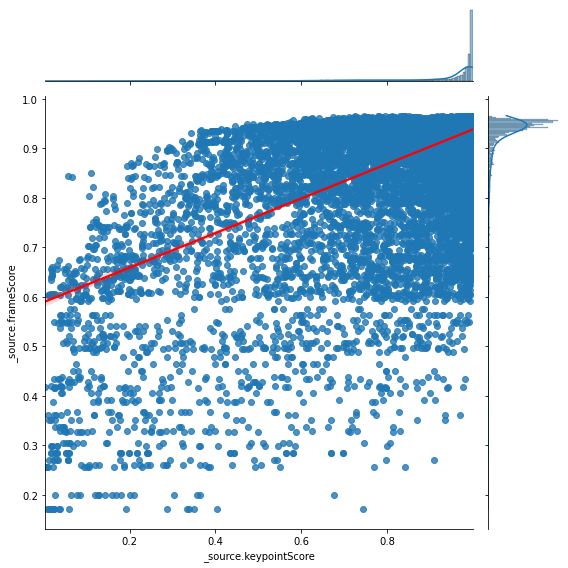

In [34]:
# Joint plot with regression line
sns.jointplot(data=df, 
              x="_source.keypointScore", 
              y="_source.frameScore", 
              kind="reg", 
              joint_kws={"line_kws":{'color':'red'}},
              height=8,
              ratio=5
            )

In [ ]:
# Bar chart for mean keypoint values
ax = df_means.plot.barh(x='_source.keypointName', 
                        y='_source.keypointScore',
                        legend = False, 
                        ylabel="Keypoint Name", 
                        xlabel="Keypoint score (%/100)")


## Model

TODO: Analyse schrijven voor meest geschikte model (hypothese naar validatie)

- PoseNet ( ? )
- MoveNet Lightning (Performance > Accuracy)
- MoveNet Thunder (Accuracy > Performance)

## Aantekeningen meeting week 2
- POSENET tensorflow library voor oefeningen gebruikt
- Ook andere modellen mogelijk (mediapipe)
- Model zsm draaiende hebben, dan zelf video opnamens maken
- Kibana (dashboard voor data te bekijken)